In [39]:
import umap

In [383]:
x = [-2, -1, 3]
y = [-3, 3, -2]

In [384]:
np.average(x)

0.0

In [40]:
import glob
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

In [62]:
def amplitude_spectrum(t, y, fmin=None, fmax=None, freq=None, oversample_factor=10.0):
    """ 
    Calculates the amplitude spectrum of a given signal
    
    Parameters
    ----------
        t : `array`
            Time values 
        y : `array`
            Flux or magnitude measurements
        fmin : float (default None)
            Minimum frequency to calculate spectrum. Defaults to df
        fmax : float
            Maximum frequency to calculate spectrum. Defaults to Nyquist.
        oversample_factor : float
            Amount by which to oversample the spectrum. Defaults to 10.
    """
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = 0.5 / np.median(np.diff(t))  # *nyq_mult
    if freq is None:
        freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4.0 / len(t))
    amp = np.sqrt(sc) * fct

    return freq, amp

In [312]:
prew = glob.glob('../prewhitening/results/PDC/frequencies/*.txt')
kics = [int(pre.split('/')[-1].split('.txt')[0]) for pre in prew]
df = pd.DataFrame({'kic': kics, 'file': prew})
# af_stars = pd.read_csv('../data/catalogues/rev_AF_stars.csv', 
# #                        dtype={'kic': str}
#                       )

bg = pd.read_csv('../data/catalogues/berger_2020.tsv', delimiter='\t')
df = pd.merge(df, bg, left_on='kic', right_on='KIC')
# df = af_stars.merge(files, left_on='KIC', right_on='kic')

# Setup

In [363]:
# plt.figure(figsize=[10,7])
all_f = []
all_a = []
all_p = []

fmax, amax = [], []
all_rhos = []
for index, row in tqdm.tqdm(df[:].iterrows(), total=len(df)):
    f, a, p = np.loadtxt(row['file'], usecols=[0, 1, 2], unpack=True, ndmin=2)
    m = f > 0
    a /= np.sinc(f / (2*24))
    all_f.append(f[m])
    all_a.append(a[m])
    all_p.append(p[m])
    
    fmax.append(f[0])
    amax.append(a[0])
    
    
#     all_rhos.append([row.logg] * len(f[m]))

100%|██████████| 2098/2098 [00:37<00:00, 55.90it/s]


/home/daniel/anaconda3/envs/UMAP/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


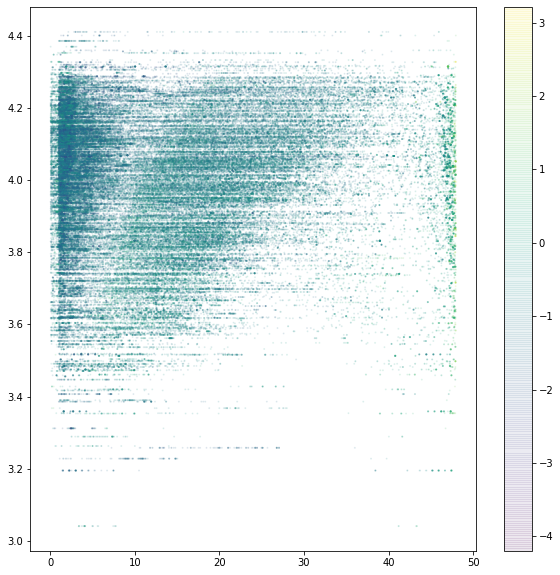

In [376]:
plt.figure(figsize=[10,10])
plt.scatter(np.hstack(all_f), np.hstack(all_rhos), c=np.log10(np.hstack(all_a)), s=1, alpha=0.1)
plt.colorbar()

In [315]:
df['fmax'] = fmax
df['amax'] = amax
sort = df.kic.values

In [ ]:
for index, row in df.itterrows():
    

In [357]:
row = df.iloc[0]

In [360]:
[row.logg] * len(all_f[0])

[3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998,
 3.9819999999999998]

In [190]:
# time, flux, err = np.loadtxt(glob.glob(f'../data/lightcurves/spline corrected PDC/lc/*{sort[0]}*.csv')[0], unpack=True)
# freq, amp = amplitude_spectrum(time, flux, oversample_factor=1, fmax=48.)

# for kic in tqdm.tqdm(sort[:]):
#     time, flux, err = np.loadtxt(glob.glob(f'../data/lightcurves/spline corrected PDC/lc/*{kic}*.csv')[0], unpack=True)
#     _, a = amplitude_spectrum(time, flux, freq=freq, oversample_factor=1.)
#     amp = np.vstack([amp, a])

In [191]:
# np.save('all_amps_berg', amp[1:,:])

# amp UMAP

In [320]:
amp = np.load('all_amps_berg.npy')
# amp = amp[1:,:]

In [321]:
amp[np.isnan(amp)] = 0

In [324]:
from scipy.stats import skew

skews = [skew(a) for a in amp]

In [326]:
amp = amp[:, 500:]

In [334]:
test = np.vstack([amp.T, skews]).T

In [338]:
amp.shape

(2101, 69555)

In [339]:
import umap

embedding = umap.UMAP(verbose=True,
#     n_neighbors=20,
#                       min_dist=0.3,
#                       metric='mahalanobis'
                     ).fit_transform(test)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set


KeyboardInterrupt: 

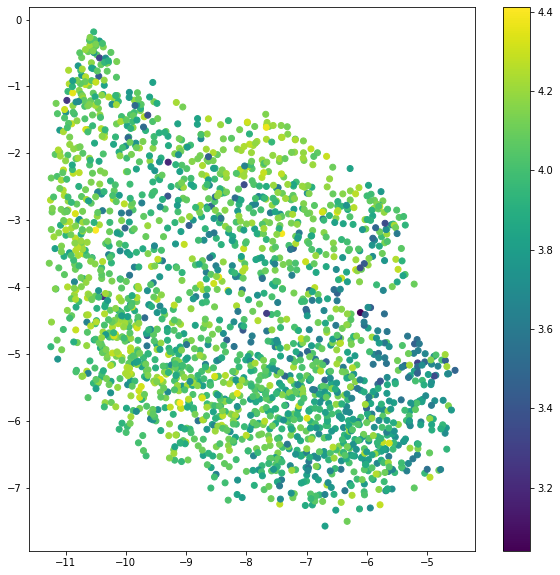

In [206]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:,0], embedding[:,1],
            c=(df.logg
              )
           )
plt.colorbar()

(0.5, 2.0)

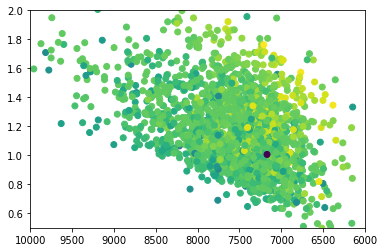

In [282]:
plt.scatter(df.Teff, df.Lum, c=df['[Fe/H]'])
plt.xlim(10000, 6000)
plt.ylim(0.5, 2.)

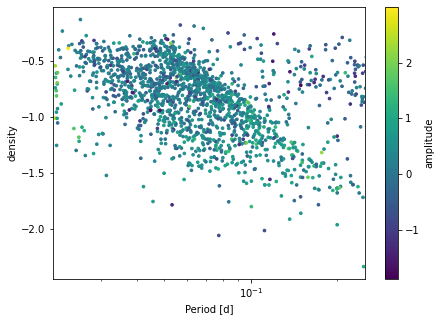

In [353]:
plt.figure(figsize=[7,5])
plt.scatter(1/df.fmax, df.rho, 
            c=np.log10(df['amax']),
           s=7)
# plt.xlim(0.1,0.2)
plt.xscale('log')
# plt.yscale('log')
plt.xlim(7**-2, 0.25)

plt.xlabel('Period [d]')
plt.ylabel('density')
# plt.ylim(3.4, 4.4)
plt.colorbar(label='amplitude')
# pl

In [356]:
df.corr()['fmax'].sort_values()

Age        -0.195642
Rad        -0.149492
TAMS       -0.092366
E_Rad      -0.077424
E_Age      -0.065699
e_Teff     -0.031718
[Fe/H]     -0.022861
Mass       -0.020302
Lum        -0.018624
e_[Fe/H]   -0.014786
E_Mass     -0.010363
e_Dist     -0.004405
kic        -0.002665
KIC        -0.002665
e_Lum      -0.000534
E_logg      0.001032
e_logg      0.003606
E_[Fe/H]    0.004832
E_Dist      0.005716
E_Lum       0.009414
Dist        0.011630
GOF         0.021495
e_Mass      0.022940
Avmag       0.036842
E_Teff      0.045470
e_Rad       0.078637
e_Age       0.084382
amax        0.107285
Teff        0.156342
rho         0.157854
E_rho       0.165560
e_rho       0.166373
logg        0.171944
fmax        1.000000
Name: fmax, dtype: float64

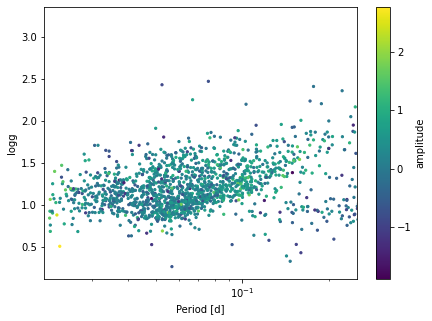

In [296]:
plt.figure(figsize=[7,5])
plt.scatter(1/df.fmax, df.Lum, 
            c=np.log10(df['amax']),
           s=5)
# plt.xlim(0.1,0.2)
plt.xscale('log')
# plt.yscale('log')
plt.xlim(7**-2, 0.25)

plt.xlabel('Period [d]')
plt.ylabel('logg')
# plt.ylim(3.4, 4.4)
plt.colorbar(label='amplitude')
# pl

In [ ]:
plt.figure(figsize=[7,5])
plt.scatter(1/df.fmax, df.logg, 
            c=np.log10(df['amax']))
# plt.xlim(0.1,0.2)
plt.xscale('log')
# plt.yscale('log')
plt.xlim(7**-2, 0.25)

plt.xlabel('Period [d]')
plt.ylabel('logg')
plt.ylim(3.4, 4.4)
plt.colorbar(label='amplitude')
# pl

In [205]:
df.corr()['fmax'].sort_values()

Age        -0.194575
Rad        -0.169074
E_Rad      -0.094410
TAMS       -0.069460
e_Teff     -0.041604
Lum        -0.039423
E_Age      -0.039098
Mass       -0.035511
[Fe/H]     -0.024044
e_Lum      -0.022096
E_Mass     -0.014865
E_Lum      -0.013701
Dist       -0.013060
E_Dist     -0.006820
E_logg     -0.001553
E_[Fe/H]   -0.001066
e_[Fe/H]    0.002336
kic         0.003128
KIC         0.003128
e_Dist      0.008010
e_logg      0.010671
Avmag       0.024183
GOF         0.024664
e_Mass      0.028559
E_Teff      0.050418
e_Age       0.059903
e_Rad       0.094619
amax        0.109465
Teff        0.154384
rho         0.181058
e_rho       0.184828
E_rho       0.184908
logg        0.194888
fmax        1.000000
Name: fmax, dtype: float64

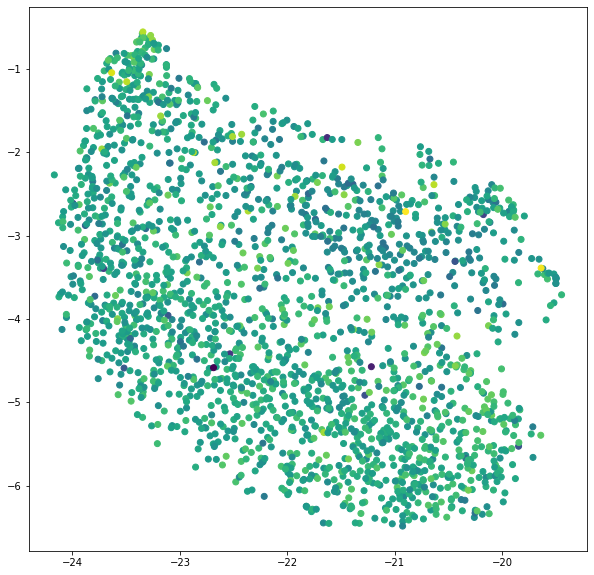

In [105]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:,0], embedding[:,1],
            c=np.log10(df.Lum)
           )

In [142]:
import numpy as np
from sklearn.manifold import TSNE

embedding = TSNE(n_components=2, 
                 perplexity=150, 
                 verbose=True).fit_transform(amp[:,::10])

[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 2101 samples in 0.137s...
[t-SNE] Computed neighbors for 2101 samples in 164.355s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2101
[t-SNE] Computed conditional probabilities for sample 2000 / 2101
[t-SNE] Computed conditional probabilities for sample 2101 / 2101
[t-SNE] Mean sigma: 0.000113
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.248566
[t-SNE] KL divergence after 1000 iterations: 1.559145


In [145]:
embedding.shape

(2101, 2)

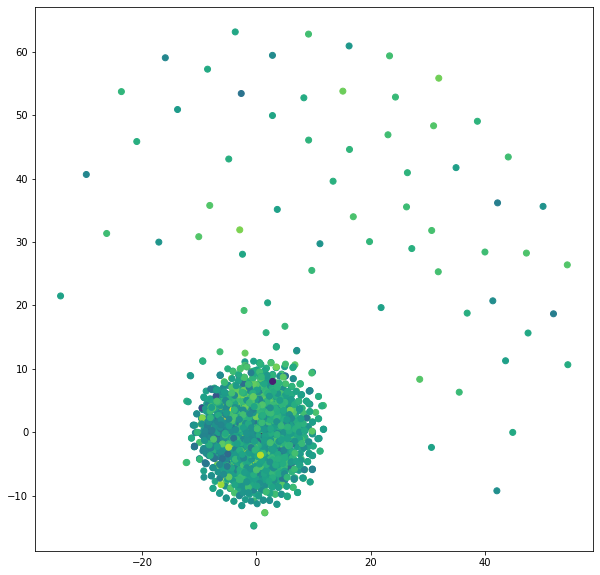

In [146]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:,0], embedding[:,1],
            c=np.log10(df.Lum)
           )

# hmm

100%|██████████| 2101/2101 [00:36<00:00, 58.14it/s]


In [6]:
import umap

In [168]:
data = np.array([np.hstack(all_f), 
#                  np.hstack(all_a)
                ]).T
data_max = np.array([fmax, amax]).T

In [170]:
import umap

embedding = umap.UMAP(
    n_neighbors=50,
#                       min_dist=0.3,
#                       metric='correlation'
                     ).fit_transform(data[:])

KeyboardInterrupt: 

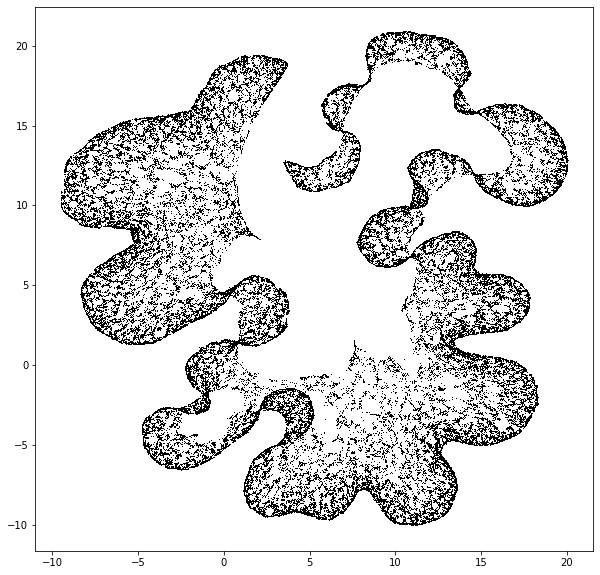

In [85]:
plt.figure(figsize=[10,10])
plt.plot(embedding[:,0], embedding[:,1], ',k'
#             c=np.log10(df.Lum)
           )

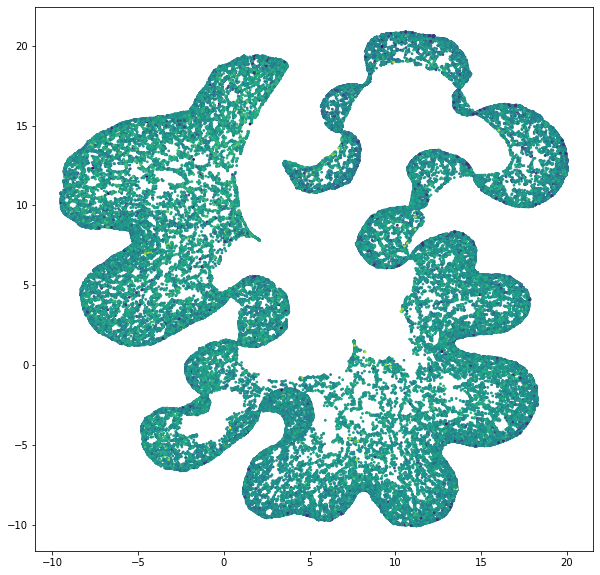

In [86]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:,0], embedding[:,1],
            c=np.log10(np.hstack(teffs)),s=3
           )
# plt.colorbar()

In [158]:
data = np.array([np.log10(np.hstack(all_f)), np.log10(np.hstack(all_a))]).T   
data.shape

(43780, 2)

In [159]:
# data = np.array([fmax, amax]).T

In [166]:
data[:,0]

array([1.13971611, 1.4141708 , 1.10341357, ..., 1.36694769, 1.30952141,
       1.38851135])

In [163]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(data[:,0])

In [164]:
len(data)

43780

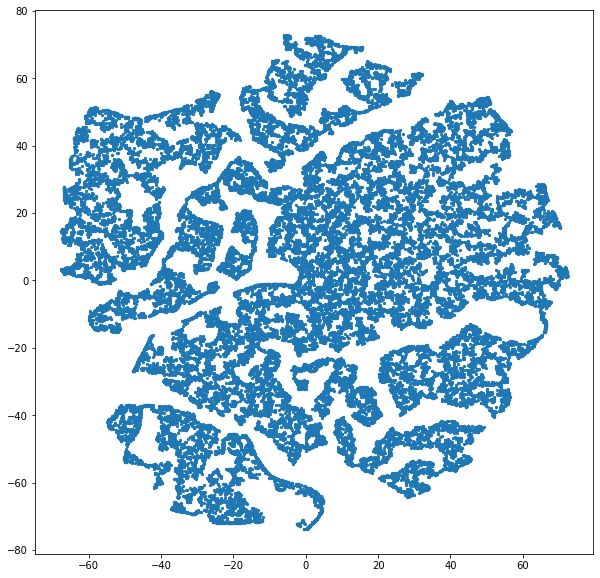

In [165]:
plt.figure(figsize=[10,10])
plt.scatter(X_embedded[:,0], X_embedded[:,1],
            c=np.log10(df.Teff),
            s=5)

In [21]:
from sklearn.datasets import load_digits

digits = load_digits()

In [24]:
digits.data.shape

(1797, 64)